In [1]:
# Import libraries
import os as os
import datetime

RAND_SEED = 12345
import numpy as np
np.random.seed(RAND_SEED)
import random
random.seed(RAND_SEED)
import pandas as pd

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [3]:
!unzip data

Archive:  data.zip
  inflating: data/Critical_Oil_Rate.csv  
  inflating: data/Threshold radius.csv  
  inflating: data/Well_Choke_GL.csv  
  inflating: data/Well_Monthly_Production.csv  
  inflating: data/Well_Rates.csv     


In [4]:
# Define directories and file names
cwd = os.getcwd()
datadir = os.path.join(cwd, 'data') 
outputdir = os.path.join(cwd, 'output')  # This directory should exists

In [5]:
class WellData:

    def __init__(self, UWI):
        self.UWI = UWI
        self.mon_alloc_dates = None
        self.prod_days = None
        self.oil_prod = None
        self.oil_prod_norm = None
        self.gas_prod = None
        self.gas_prod_norm = None
        self.water_prod = None
        self.water_prod_norm = None
        self.last_cont_prod_idx = -1
        self.cont_prod_dates = None
        self.cum_oil_prod = None
        self.cum_oil_prod_norm = None
        self.cum_gas_prod = None
        self.cum_gas_prod_norm = None
        self.cum_water_prod = None
        self.cum_water_prod_norm = None
        self.cum_water_cut = -1.
        self.is_dead_well = False
        self.sub_cluster_id = -1

In [6]:
class SubCluster:
    
    def __init__(self, sub_cluster_id, sub_cluster_name):
        self.sub_cluster_id = sub_cluster_id
        self.sub_cluster_name = sub_cluster_name
        self.num_wells = 0
        self.num_dead_wells = 0
        self.dead_well_prob = 0.
        self.cum_water_cut_list = []
        self.cum_water_cut_avg = 0.
        self.cum_water_cut_min = 0.
        self.cum_water_cut_max = 0.

In [7]:
def parse_date(date_str):
    """
    :param date_str: Date string in DD-MON-YY format
    :return date: Date in format with year as YYYY
    """
    if str(date_str) == 'nan':
        return 'UNKNOWN'
    date = datetime.datetime.strptime(date_str,'%d-%b-%y')
    if date.year > 2050:
        date = date.replace(year=(date.year - 100))
    return date

In [8]:
def process_dates(start_dates_str):
    start_dates_all = []
    for date_str in start_dates_str:
        start_dates_all.append(parse_date(date_str))
    sort_dates = np.sort(start_dates_all)
    sort_idxs = np.argsort(start_dates_all)
    sum_idxs = []
    num_dates = len(start_dates_all)
    j = None
    start_dates = []
    for i in range(num_dates):
        if j == None:
            j = i
        if i == j:
            j_sum_idxs = []
            j_sum_idxs.append(sort_idxs[j])
            has_duplicate = True
            while has_duplicate:
                if j < (num_dates - 1):
                    if sort_dates[j + 1] == sort_dates[j]:
                        j_sum_idxs.append(sort_idxs[j + 1])
                        j = j + 1
                    else:
                        start_dates.append(sort_dates[j])
                        has_duplicate = False
                        j = j + 1
                else:
                    start_dates.append(sort_dates[j])
                    has_duplicate = False
                    j = j + 1
            sum_idxs.append(j_sum_idxs)
    return start_dates, sum_idxs

In [9]:
def summarize_monthly_productions(prod_all, sum_idxs, max_prod):
    num_rec = len(sum_idxs)
    #print('num_rec %d' % num_rec)
    prod_sum = []
    for i in range(num_rec):
        prod_i = 0.
        num_idxs = len(sum_idxs[i])
        for j in range(num_idxs):
            prod_i = prod_i + prod_all[sum_idxs[i][j]]
        prod_sum.append(prod_i)
    if max_prod == None:
        max_prod = np.max(prod_sum)
    if max_prod > 1e-3:
        prod_norm = prod_sum / max_prod
    else:
        prod_norm = prod_sum * 0.
    return prod_sum, prod_norm, max_prod

In [10]:
def populate_monitoring_alloc(well_mon_alloc_file, wells, min_hist_points):
    op_df = pd.read_csv(well_mon_alloc_file)
    num_rec = op_df.shape[0]
    print("Read %d operations records." % num_rec)
    #print(op_df.head(10))
    num_wells = 0
    num_dead = 0
    dead_UWI = []
    for well in wells:
        #print(well.UWI)
        start_dates_str = op_df[op_df['UWI'] == well.UWI].START_DATE.values
        start_dates, sum_idxs = process_dates(start_dates_str)
        num_dates = len(start_dates)
        if num_dates > min_hist_points:
            num_wells = num_wells + 1
            #print(len(start_dates))
            #print(start_dates)
            #print(sum_idxs)
            #print(len(sum_idxs))
            well.mon_alloc_dates = start_dates
            oil_prod_all = op_df[op_df['UWI'] == well.UWI].OIL.values
            oil_prod, oil_prod_norm, max_prod = summarize_monthly_productions(oil_prod_all, sum_idxs, None)
            gas_prod_all = op_df[op_df['UWI'] == well.UWI].GAS.values
            gas_prod, gas_prod_norm, _ = summarize_monthly_productions(gas_prod_all, sum_idxs, max_prod)
            water_prod_all = op_df[op_df['UWI'] == well.UWI].WATER.values
            water_prod, water_prod_norm, _ = summarize_monthly_productions(water_prod_all, sum_idxs, max_prod)
            well.oil_prod = oil_prod
            well.oil_prod_norm = oil_prod_norm
            well.gas_prod = gas_prod
            well.gas_prod_norm = gas_prod_norm
            well.water_prod = water_prod
            well.water_prod_norm = water_prod_norm
            if well.oil_prod[-1] == 0.:
                well.is_dead_well = True
                num_dead = num_dead + 1
                dead_UWI.append(well.UWI)
    print('Found %d qualifying wells.' % num_wells)
    print('Found %d dead wells.' % num_dead)
    return wells, dead_UWI

In [11]:
def find_continous_data(wells):
    for well in wells:
        dates = well.mon_alloc_dates
        if dates != None:
            #print(well.UWI)
            num_dates = len(dates)
            for i in range(num_dates - 1):
                diff_days = (dates[i + 1] - dates[i]).days
                if diff_days in range (28, 32):
                    well.last_cont_prod_idx = (i + 1)
                else:
                    break
            well.cont_prod_dates = well.mon_alloc_dates[:(well.last_cont_prod_idx + 1)]
    return wells

In [12]:
def populate_cumulative_production(wells, min_hist_points, do_plot):
    for well in wells:
        num_hist_points = well.last_cont_prod_idx + 1
        if num_hist_points >= min_hist_points:
            cum_oil = []
            cum_gas = []
            cum_water = []
            for i in range(num_hist_points):
                if i == 0:
                    cum_oil.append(well.oil_prod[0])
                    cum_gas.append(well.gas_prod[0])
                    cum_water.append(well.water_prod[0])
                else:
                    cum_oil.append(cum_oil[-1] + well.oil_prod[i])
                    cum_gas.append(cum_gas[-1] + well.gas_prod[i])
                    cum_water.append(cum_water[-1] + well.water_prod[i])
            well.cum_oil_prod = cum_oil
            well.cum_gas_prod = cum_gas
            well.cum_water_prod = cum_water
            well.cum_water_cut = (cum_water[-1] * 100. / (cum_water[-1] + cum_oil[-1]))
            max_cum_oil = np.max(cum_oil)
            well.cum_oil_prod_norm = cum_oil / max_cum_oil
            well.cum_gas_prod_norm = cum_gas / max_cum_oil
            well.cum_water_prod_norm = cum_water / max_cum_oil
    return wells

In [13]:
def prepare_clustering_features(wells, min_cont_hist_points):
    feat_mat = []
    feat_mat_norm = []
    list_UWI = []
    for well in wells:
        if (well.last_cont_prod_idx + 1) >= min_cont_hist_points:
            list_UWI.append(well.UWI)
            feat_mat.append(well.cum_oil_prod[:min_cont_hist_points])
            prod_norm = well.cum_oil_prod_norm[:min_cont_hist_points]
            prod_norm = prod_norm / prod_norm[-1]
            feat_mat_norm.append(prod_norm)
    feat_mat = np.array(feat_mat)
    feat_mat_norm = np.array(feat_mat_norm)
    print('Added ' + str(feat_mat.shape[0]) + ' wells to the feature matrix, '
          + 'which had more than ' + str(min_cont_hist_points) + ' months of ' 
          + 'continuous production data.')
    return list_UWI, feat_mat, feat_mat_norm

In [14]:
def compute_well_clusters(list_UWI, feat, num_clust):
    clusters = {}
    kmeans = KMeans(init='k-means++', n_clusters=num_clust, n_init=20)
    kmeans.fit(feat)
    clust = kmeans.predict(feat)
    num_wells = len(list_UWI)
    for i in range(num_wells):
        clusters[list_UWI[i]] = clust[i]
    return clusters, kmeans

In [15]:
def prepare_elbow_plot(list_UWI, feat, max_clusters, out_file):
    # Elbow represent the optimal number of clusters in the mean of 
    # sum of squared distances (<SSD>) from cluster centroid vs number 
    # of clusters plot.
    ssd = []
    cluster_range = range(1, (max_clusters + 1))
    for n_clusters in cluster_range:
        clusters, kmeans = compute_well_clusters(list_UWI, feat, n_clusters)
        ssd.append(sum(np.min(cdist(feat, kmeans.cluster_centers_, 
                                    "euclidean"), axis=1)) / feat.shape[0])
    # Plot the <SSD> vs number of clusters
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes()
    plt.plot(cluster_range, ssd, 'r-', label='<SSD vs No. Clust.>', linewidth=2)
    plt.xlabel("Number of Clusters", fontweight="bold")
    plt.ylabel("<SSD>", fontweight="bold")
    plt.title("Elbow Plot for KMeans Clustering", fontweight="bold")
    plt.grid(b=True, which='major', color='k', linestyle='--')
    for item in ([ax.title]):
        item.set_fontsize(16)
        item.set_weight('bold')
    for item in ([ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(14)
        item.set_weight('bold')
    fig.savefig(out_file, bbox_inches='tight', dpi=300)

In [16]:
def plot_cluster_prod_data(wells, clust, colors,
                           list_UWI, min_cont_hist_points, kmeans):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes()
    dates = None
    y_max = 0.
    dates = range(min_cont_hist_points)
    for well in wells:
        if well.UWI in list_UWI:
            style = colors[clust[well.UWI]] + '-'
            y = well.cum_oil_prod[:min_cont_hist_points]
            y = [yi / 249.  for yi in y]
            ax.plot(dates, y, style, linewidth=2)
            if y[-1] > y_max:
                y_max = y[-1]
    ax.set(xlabel='Months',
           ylabel='Cum. Production',
           title='Cumulative Production')
    for center in kmeans.cluster_centers_:
        center = [c / 249. for c in center]
        ax.plot(dates, center, color='k', linestyle='--', linewidth=4)
    leg_props = {'weight':'bold', 'size':18}
    leg = ax.legend(loc=2, prop=leg_props)
    leg.get_frame().set_linewidth(0.0)
    fig.autofmt_xdate()
    plt.grid(b=True, which='major', color='k', linestyle='--')
    x_min = np.min(dates)
    x_max = np.max(dates)
    y_min = 0.
    y_max = 1.05 * y_max
    ax.set_xlim(xmin=x_min, xmax=x_max)
    ax.set_ylim(ymin=y_min, ymax=y_max)
    for item in ([ax.title]):
        item.set_fontsize(20)
        item.set_weight('bold')
    for item in ([ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(18)
        item.set_weight('bold')
        plt.setp(ax.get_xticklabels(), fontsize=16, weight='bold')
    plt.setp(ax.get_yticklabels(), fontsize=16, weight='bold')    
    fig.savefig(os.path.join(outputdir, 'cluster_prod.png'), bbox_inches='tight', dpi=300)

In [17]:
def plot_cluster_prod_data_norm(wells, clust_norm, colors, 
                                list_UWI, min_cont_hist_points, kmeans):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes()
    dates = range(min_cont_hist_points)
    for well in wells:
        if well.UWI in list_UWI:
            style = colors[clust_norm[well.UWI]] + '-'
            y = well.cum_oil_prod_norm[:min_cont_hist_points]
            y = y / y[-1]
            ax.plot(dates, y, style, linewidth=2)
    ax.set(xlabel='Months',
           ylabel='Norm. Cum. Production',
           title='Normalized Cumulative Production')
    for center in kmeans.cluster_centers_:
        ax.plot(dates, center, color='k', linestyle='--', linewidth=4)
    leg_props = {'weight':'bold', 'size':18}
    leg = ax.legend(loc=2, prop=leg_props)
    leg.get_frame().set_linewidth(0.0)
    fig.autofmt_xdate()
    plt.grid(b=True, which='major', color='k', linestyle='--')
    x_min = np.min(dates)
    x_max = np.max(dates)
    y_min = 0.
    y_max = 1.05
    ax.set_xlim(xmin=x_min, xmax=x_max)
    ax.set_ylim(ymin=y_min, ymax=y_max)
    for item in ([ax.title]):
        item.set_fontsize(20)
        item.set_weight('bold')
    for item in ([ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(18)
        item.set_weight('bold')
    plt.setp(ax.get_xticklabels(), fontsize=16, weight='bold')
    plt.setp(ax.get_yticklabels(), fontsize=16, weight='bold')
    fig.savefig(os.path.join(outputdir, 'cluster_prod_norm.png'), bbox_inches='tight', dpi=300)

In [18]:
def swap_prod_clusters(clusters):
    # Here we have to swap cluster ID 0 & 2,
    # followed by swapping cluster ID 1 & 2.
    # After swap, clusters will correspond to
    # 0 - low producing
    # 1 - medium producing
    # 2 - high producing
    for key in clusters.keys():
        if clusters[key] == 0:
            clusters[key] = 2
        elif clusters[key] == 2:
            clusters[key] = 0
    for key in clusters.keys():
        if clusters[key] == 1:
            clusters[key] = 2
        elif clusters[key] == 2:
            clusters[key] = 1
    return clusters

In [19]:
def swap_prod_norm_clusters(clusters_norm):
    # Here we have to swap cluster ID 0 & 2,
    # followed by swapping cluster ID 0 & 1.
    # After swap, clusters will correspond to
    # 0 - decreasing production
    # 1 - steady production
    # 2 - increasing production
    for key in clusters_norm.keys():
        if clusters_norm[key] == 0:
            clusters_norm[key] = 2
        elif clusters_norm[key] == 2:
            clusters_norm[key] = 0
    for key in clusters_norm.keys():
        if clusters_norm[key] == 0:
            clusters_norm[key] = 1
        elif clusters_norm[key] == 1:
            clusters_norm[key] = 0
    return clusters_norm

In [20]:
def assign_sub_cluster_id(wells, clusters, clusters_norm):
    i = 0
    UWIs = clusters.keys()
    for well in wells:
        UWI = well.UWI
        if UWI in UWIs:
            well.sub_cluster_id = 10 * (clusters[UWI] + 1) + (clusters_norm[UWI] + 1)
            i = i + 1
            #print(well.sub_cluster_id)
    print('Assigned %d cluster IDs.' % i)
    return wells

In [21]:
def populate_sub_clusters(wells):
    subclusters = {}
    name_id_dict = {}
    name_id_dict[11] = 'Low Oil Cumulative & Declining Rate'
    name_id_dict[12] = 'Low Oil Cumulative & Steady Rate'
    name_id_dict[13] = 'Low Oil Cumulative & Increasing Rate'
    name_id_dict[21] = 'Medium Oil Cumulative & Declining Rate'
    name_id_dict[22] = 'Medium Oil Cumulative & Steady Rate'
    name_id_dict[23] = 'Medium Oil Cumulative & Increasing Rate'
    name_id_dict[31] = 'High Oil Cumulative & Declining Rate'
    name_id_dict[32] = 'High Oil Cumulative & Steady Rate'
    name_id_dict[33] = 'High Oil Cumulative & Increasing Rate'
    for key in name_id_dict.keys():
        clust = SubCluster(key, name_id_dict[key])
        subclusters[key] = clust

    for well in wells:
        sub_clust_id = well.sub_cluster_id
        if sub_clust_id > -1:
            #print(sub_clust_id)
            clust = subclusters[sub_clust_id]
            #print(clust)
            clust.num_wells = clust.num_wells + 1
            # print(clust.num_wells)
            if well.is_dead_well == True:
                clust.num_dead_wells = clust.num_dead_wells + 1
                #print(clust.num_dead_wells)
            clust.cum_water_cut_list.append(well.cum_water_cut)
            #print(clust.cum_water_cut_list)
            subclusters[sub_clust_id] = clust
    for key in name_id_dict.keys():
        clust = subclusters[key]
        if clust.num_wells > 0:
            clust.cum_water_cut_avg = np.average(clust.cum_water_cut_list)
            clust.cum_water_cut_min = np.min(clust.cum_water_cut_list)
            clust.cum_water_cut_max = np.max(clust.cum_water_cut_list)
            clust.dead_well_prob = float(clust.num_dead_wells) / float(clust.num_wells)
        subclusters[key] = clust
    return subclusters

In [22]:
def print_sub_clusters_info(sub_clusters):
    clusts = list(sub_clusters.values())
    for clust in clusts:
        print('Cluster ID: %d' % clust.sub_cluster_id)
        print('Cluster Name: %s' % clust.sub_cluster_name)
        print('Number of Wells: %d' % clust.num_wells)
        print('Number of Dead Wells: %d' % clust.num_dead_wells)
        print('Dead Wells Probability: %f' % clust.dead_well_prob)
        print('Average Cum. Water Cut: %f' % clust.cum_water_cut_avg)
        print('***********************************************')

In [23]:
def compute_wcut_dead_well_corr(sub_clusters):
    dead_prob = []
    water_cut = []
    clusts = list(sub_clusters.values())
    for clust in clusts:
        dead_prob.append(clust.dead_well_prob)
        water_cut.append(clust.cum_water_cut_avg)
    cor_coeff = np.corrcoef(dead_prob, water_cut)
    return cor_coeff

In [24]:
### 1. Path to Production History file
well_mon_alloc_file = os.path.join(datadir, 'Well_Monthly_Production.csv')

In [25]:
### 2. Create a list of Well objects
df_wells = pd.read_csv(well_mon_alloc_file)
wells_UWI = df_wells.UWI.values
unique_UWI = np.unique(wells_UWI)
wells = []
for uwi in unique_UWI:
    well = WellData(uwi)
    wells.append(well)

In [26]:
### 3. Find dead_UWI, Plot wells if needed
wells, dead_UWI = populate_monitoring_alloc(well_mon_alloc_file, wells, 3)

Read 79392 operations records.
Found 329 qualifying wells.
Found 63 dead wells.


In [27]:
### 4. Find continous production data
wells = find_continous_data(wells)
wells = populate_cumulative_production(wells, 3, False)

In [28]:
### 5. Prepare feature matrix for wells with min_point continuous
min_points = 24
list_UWI, feat_mat, feat_mat_norm = prepare_clustering_features(wells, min_points)

Added 227 wells to the feature matrix, which had more than 24 months of continuous production data.


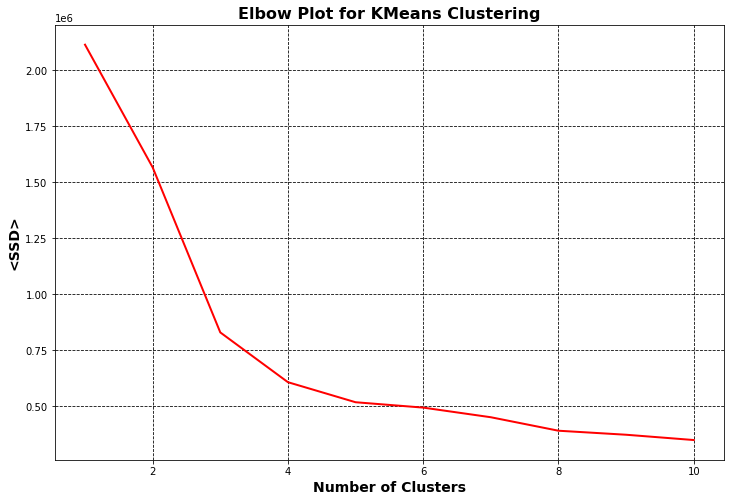

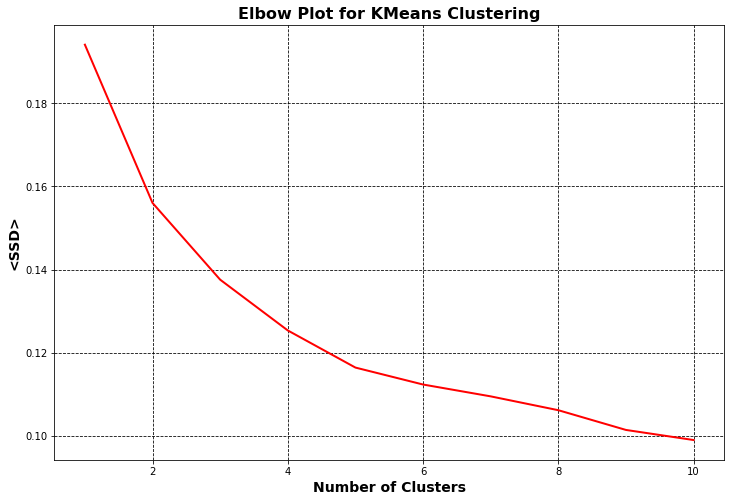

In [29]:
### 6. Make elbow plot for KMeans Clustering and feature matrix
max_clusters = 10
out_file = os.path.join(outputdir, 'elbow.png')
prepare_elbow_plot(list_UWI, feat_mat, max_clusters, out_file)
out_file = os.path.join(outputdir, 'elbow_norm.png')
prepare_elbow_plot(list_UWI, feat_mat_norm, max_clusters, out_file)

In [30]:
### 7. Compute clusters
clusters, kmeans = compute_well_clusters(list_UWI, feat_mat, 3)
clusters = swap_prod_clusters(clusters)
clusters_norm, kmeans_norm = compute_well_clusters(list_UWI, feat_mat_norm, 3)
clusters_norm = swap_prod_norm_clusters(clusters_norm)

No handles with labels found to put in legend.


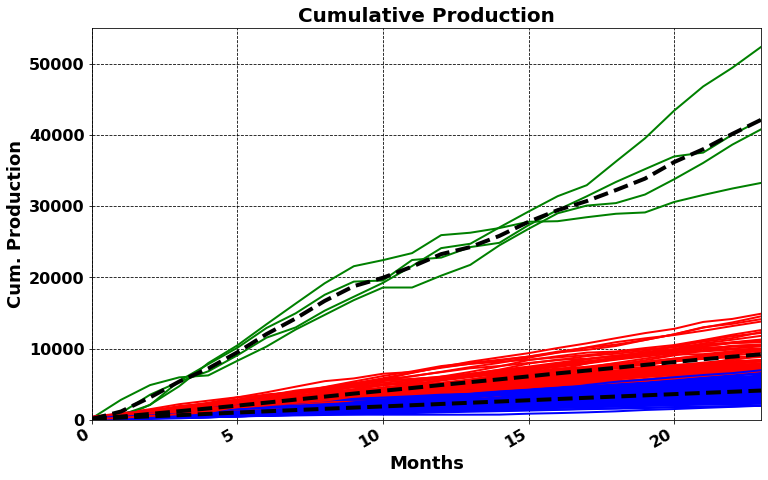

In [31]:
### 8. Plot cumulative production colored by cluster assignments
colors = ['r', 'b', 'g']
plot_cluster_prod_data(wells, clusters, colors, list_UWI, min_points, kmeans)

No handles with labels found to put in legend.


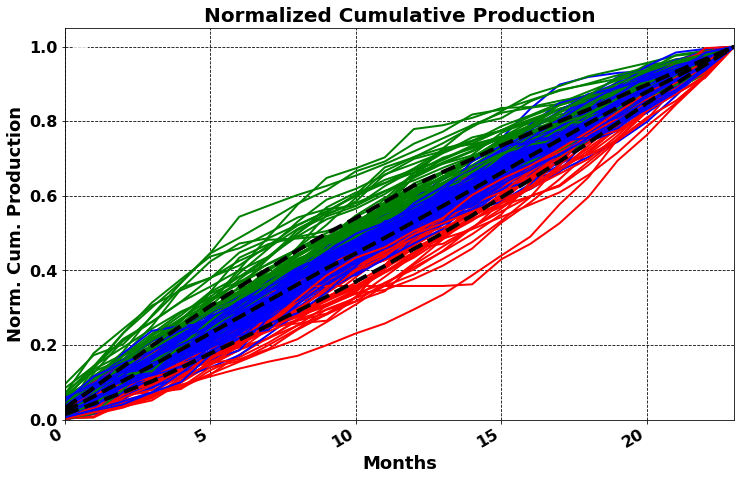

In [32]:
# plot normalized cumulative production
plot_cluster_prod_data_norm(wells, clusters_norm, colors, list_UWI, min_points, kmeans_norm)

In [33]:
### 9. Assign wells to clusters, populate subclusters and print subclusters
wells = assign_sub_cluster_id(wells, clusters, clusters_norm)
sub_clusters = populate_sub_clusters(wells)
print_sub_clusters_info(sub_clusters)

Assigned 227 cluster IDs.
Cluster ID: 11
Cluster Name: Low Oil Cumulative & Declining Rate
Number of Wells: 14
Number of Dead Wells: 5
Dead Wells Probability: 0.357143
Average Cum. Water Cut: 2.673662
***********************************************
Cluster ID: 12
Cluster Name: Low Oil Cumulative & Steady Rate
Number of Wells: 31
Number of Dead Wells: 8
Dead Wells Probability: 0.258065
Average Cum. Water Cut: 4.497392
***********************************************
Cluster ID: 13
Cluster Name: Low Oil Cumulative & Increasing Rate
Number of Wells: 13
Number of Dead Wells: 4
Dead Wells Probability: 0.307692
Average Cum. Water Cut: 3.459154
***********************************************
Cluster ID: 21
Cluster Name: Medium Oil Cumulative & Declining Rate
Number of Wells: 21
Number of Dead Wells: 4
Dead Wells Probability: 0.190476
Average Cum. Water Cut: 4.123413
***********************************************
Cluster ID: 22
Cluster Name: Medium Oil Cumulative & Steady Rate
Number of Wells:

In [34]:
### 10. Compute wct correlation to dead well probability
corr = compute_wcut_dead_well_corr(sub_clusters)
print('Avg. Cum. Water Cut - Dead Well Prob. Corr. Coeff.: %f' % corr[1][0])

Avg. Cum. Water Cut - Dead Well Prob. Corr. Coeff.: 0.719563
